# Testing software

In [65]:
import numpy as np
from matplotlib import pyplot as plt
import stan_utility
import corner

## Sources

Decided to go with the astromodels package as python3 branch is working well.

To install: 
```
pip install git+https://github.com/giacomov/astromodels.git@py2to3
```

In [66]:
from python.source.source import *
from astromodels.functions.functions import Powerlaw
from astromodels import Model

In [67]:
# Single source
source = PointSource('point', ra=0.0, dec=0.0, redshift=0.1, unit_vector = [1, 0, 0], spectral_shape=Powerlaw())
source.position.get_ra()
source.redshift

0.1

In [68]:
#source_list = ManualSourceList([source])
#zth = 1
#diffuse_bg = DiffuseSource('diffuse_bg', zth, spectral_shape=Powerlaw())
#source_list.add(diffuse_bg)

In [69]:
# Loading from file
source_file = '../dev/statistical_model/data/test_SFR_pop.h5'
source_list = TestSourceList(source_file, spectral_shape=Powerlaw())

# Select sources below zth = 1
zth = 1
source_list.select_below_redshift(zth)

# Add a diffuse background at z = 1
diffuse_bg = DiffuseSource('diffuse_bg', zth, spectral_shape=Powerlaw())
source_list.add(diffuse_bg)

In [70]:
# Could also use an astromodels model
source_model = Model(*source_list.sources)

## Precomputation

In [146]:
from python.Precomputation import ExposureIntegral
from python.detector_model import NorthernTracksEffectiveArea

In [147]:
time = 8 # years -> not used rn
Emin = 1.0e5 # GeV

exposure_integral = ExposureIntegral(source_list, NorthernTracksEffectiveArea, 
                                     time, Emin)
exposure_integral()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x124a7ed90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11dff4f50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11c4fd550> already on stack


/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


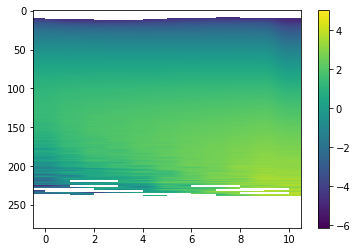

In [148]:
fig, ax = plt.subplots()
plt.imshow(np.log10(exposure_integral._effective_area._eff_area), aspect='auto')
plt.colorbar()

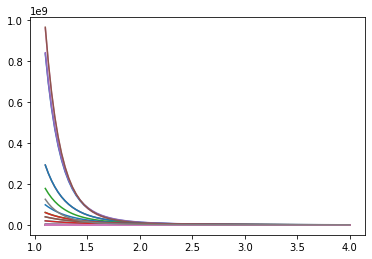

In [149]:
fig, ax = plt.subplots()
for _ in exposure_integral.integral_grid:
    ax.plot(exposure_integral.alpha_grid, _)

## Generate Stan code for simulation


In [150]:
from python.detector_model import NorthernTracksDetectorModel
from python.backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext, TransformedDataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator, WhileLoopContext)
from python.backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from python.backend.expression import StringExpression
from python.backend.parameterizations import DistributionMode
import logging
logging.basicConfig(level=logging.WARN)

In [154]:
with StanFileGenerator("stan_files/sim_code") as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("sim_functions.stan")
        _ = Include("energy_spectrum.stan")
            
    with DataContext() as dc:
        
        # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        redshift = ForwardVariableDef("z", "vector[Ns+1]")
        
        # Energies
        alpha = ForwardVariableDef("alpha", "real")
        Emin = ForwardVariableDef("Emin", "real")
        
        # Flux
        Q = ForwardVariableDef("Q", "real")
        F0 = ForwardVariableDef("F0", "real")
        
        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        Ngrid_str = ["[", Ngrid, "]"]
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        aeff_max = ForwardVariableDef("aeff_max", "real")
        
        # Inputs
        T = ForwardVariableDef("T", "real")
        
    with TransformedDataContext() as tdc:
        F = ForwardVariableDef("F", "vector[Ns+1]")
        FT = ForwardVariableDef("FT", "real")
        Fs = ForwardVariableDef("Fs", "real")
        f = ForwardVariableDef("f", "real")
        w_exposure = ForwardVariableDef("w_exposure", "simplex[Ns+1]")
        Nex = ForwardVariableDef("Nex", "real")
        N = ForwardVariableDef("N", "int")
        eps = ForwardVariableDef("eps", "vector[Ns+1]")
        
        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([Q, "/ (4 * pi() * pow(", 
                                         D[k], " * ", 3.086e22, ", 2))"])
            StringExpression([Fs," += ", F[k]])
        
        StringExpression("F[Ns+1]") << F0
        
        FT << Fs + FT
        f << StringExpression([Fs, "/", FT])
        
        eps << StringExpression(["get_exposure_factor(", T, ", ", Emin, ", ", alpha, 
                                 ", ", alpha_grid, ", ", integral_grid, ", ", Ns, ")"])
        Nex << StringExpression(["get_Nex(", F, ", ", eps, ")"])
        w_exposure << StringExpression(["get_exposure_weights(", F, ", ", 
                                              eps, ")"])
        N << StringExpression(["poisson_rng(", Nex, ")"])
        StringExpression(["print(", w_exposure, ")"])
        StringExpression(["print(", Ngrid, ")"])
        StringExpression(["print(", Nex, ")"])
        StringExpression(["print(", N, ")"])
        
    with GeneratedQuantitiesContext() as gqc:
        ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
        
        N_str = ["[", N, "]"]
        lam = ForwardArrayDef("Lambda", "int", N_str)
        omega = ForwardVariableDef("omega", "unit_vector[3]")
        
        Esrc = ForwardVariableDef("Esrc", "vector[N]")
        E = ForwardVariableDef("E", "vector[N]")
        Edet = ForwardVariableDef("Edet", "vector[N]")
        
        cosz = ForwardArrayDef("cosz", "real", N_str)
        Pdet = ForwardArrayDef("Pdet", "real", N_str)
        accept = ForwardVariableDef("accept", "int")
        ntrials = ForwardVariableDef("ntrials", "int")
        prob = ForwardVariableDef("prob", "simplex[2]")
        
        event = ForwardArrayDef("event", "unit_vector[3]", N_str)
        Nex_sim = ForwardVariableDef("Nex_sim", "real")
        
        Nex_sim << Nex

        with ForLoopContext(1, N, "i") as i:
            
            lam[i] << StringExpression(["categorical_rng(", w_exposure,")"])
            
            accept << 0
            ntrials << 0
            
            with WhileLoopContext([accept != 1]):
                
            
                StringExpression([#lam[i], " = categorical_rng(", w_exposure, ");\n",
                                  "if (", lam[i], " < Ns+1) {\n",
                                  omega, " = ", varpi[lam[i]], ";\n",
                                  #omega, " = sphere_rng(1);\n"
                                  "}\n", "else if (", lam[i], " == Ns+1) {\n", 
                                  omega, " = sphere_rng(1);\n", "}"])

                cosz[i] << StringExpression(["cos(omega_to_zenith(", omega, "))"])

                # Sample energy
                Esrc[i] << StringExpression(["spectrum_rng(", alpha, ", ", 
                                             Emin, " * (1+", redshift[lam[i]], ") )"])
                E[i] << StringExpression([Esrc[i], "/ (1+", redshift[lam[i]], ")"])


                # Test against Aeff
                StringExpression(["if (", cosz[i], " >= 0.1) {\n", 
                                  Pdet[i], " = 0;\n",
                                 "}\n", "else {\n",
                                 Pdet[i], " = ", ntd_pdf.effective_area(E[i], omega), 
                                  " / ", aeff_max, ";\n",
                                 "}"])
                prob[1] << Pdet[i]
                prob[2] << 1 - Pdet[i]
                StringExpression([ntrials, " += ", 1])
                StringExpression(["if (", ntrials, " < 10000) {\n", 
                                 accept, " = categorical_rng(", prob, ");\n", "}\n",
                                 "else {\n",
                                 accept, " = 1;\n", 
                                  "print(\"problem component: \", ", lam[i], ");\n",
                                  "}"])
                #accept << StringExpression(["categorical_rng(", prob, ")"])
            
            # Detection effects
            event[i] << ntd_rng.angular_resolution(E[i], omega)
            Edet[i] << StringExpression(["pow(10,", 
                                         ntd_rng.energy_resolution(E[i]), ")"])
        
        
    sim = cg.generate_single_file()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x12496b9d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x12496b350> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x124ad8b10> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x12496b550> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x12537f790> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x12537ffd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x12537f6d0> already on stack
INFO:python.backend.code_ge

In [155]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]

sm = stan_utility.compile_model(filename=cg.filename, include_paths=include_paths, 
                                model_name="sim")

Using cached StanModel


## Simulation

In [156]:
from python.joint_model_cascades import luminosity_distance

redshift = [source_list.sources[i].redshift for i in range(source_list.N)]
lum_dist = [luminosity_distance(_) for _ in redshift]
varpi_in = [source_list.sources[i].unit_vector/np.linalg.norm(source_list.sources[i].unit_vector) for i in range(source_list.N-1)]

In [157]:
# Inputs 
sim_inputs = {}
sim_inputs['Ns'] = source_list.N-1

sim_inputs['z'] = redshift
sim_inputs['D'] = lum_dist[:-1]
sim_inputs['varpi'] = varpi_in

sim_inputs['Ngrid'] = len(exposure_integral.alpha_grid)
sim_inputs['alpha_grid'] = exposure_integral.alpha_grid
sim_inputs['integral_grid'] = exposure_integral.integral_grid

sim_inputs['aeff_max'] = np.max(exposure_integral.effective_area._eff_area)

In [158]:
sim_inputs['aeff_max'] = 1e4

In [159]:
sim_inputs['alpha'] = 2.0
sim_inputs['Emin'] = 1e5 # GeV

total_flux = 3.0 # m^-2 yr^-1
f = 0.5

sim_inputs['T'] = 1 # yr
sim_inputs['F0'] = ((1 - f) * total_flux) # m^-2 yr^-1
sim_inputs['Q'] = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*3.086e22)**2) 
                                          for d in sim_inputs['D']])) ) # yr^-1

In [160]:
# Simulate
simulation = sm.sampling(data=sim_inputs, iter=1, chains=1, 
                         algorithm="Fixed_param")

In [161]:
from astropy.coordinates import SkyCoord
from astropy import units as u

class Direction():
    """
    Input the unit vector vMF samples and
    store x, y, and z and galactic coordinates
    of direction in Mpc.
    """

    def __init__(self, unit_vector_3d):
        """
        Input the unit vector samples and
        store x, y, and z and galactic coordinates
        of direction in Mpc.

        :param unit_vector_3d: a 3-dimensional unit vector.
        """

        self.unit_vector = unit_vector_3d
        transposed_uv = np.transpose(self.unit_vector)
        self.x = transposed_uv[0]
        self.y = transposed_uv[1]
        self.z = transposed_uv[2]
        self.d = SkyCoord(self.x, self.y, self.z,
                          unit = 'mpc',
                          representation_type = 'cartesian',
                          frame = 'icrs')
        self.d.representation_type = 'spherical'
        self.lons = self.d.galactic.l.wrap_at(360 * u.deg).deg
        self.lats = self.d.galactic.b.wrap_at(180 * u.deg).deg

In [162]:
# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet_sim = simulation.extract(['Edet'])['Edet'][0]

# Arrival directions
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad


true_dir = simulation.extract(['omega'])['omega'][0]
true_dir = Direction(true_dir)
e_t_ra = true_dir.d.icrs.ra.rad
e_t_dec = true_dir.d.icrs.dec.rad

source = Direction(varpi_in)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

# event type
#event_type = simulation.extract(['event_type'])['event_type'][0]
#zenith = simulation.extract(['zenith'])['zenith'][0]

In [163]:
lam = simulation.extract(['Lambda'])['Lambda'][0] - 1
Nc = sim_inputs['Ns']
label_cmap = plt.cm.get_cmap('plasma', Nc+1)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)
print('w_bg: ', Nbg / (Nbg+Nsrc))

Nsrc:  44
Nbg:  46
w_bg:  0.5111111111111111


In [164]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

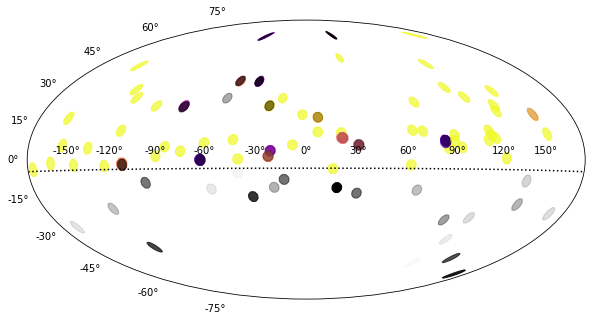

In [165]:
fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(111, projection='hammer')

circles = []
for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    circles.append(mpatches.Circle((r-np.pi,d), 0.05, color=color, alpha=0.7))
collection = PatchCollection(circles, match_original=True)    
ax.add_collection(collection)   

circles = []
norm = max([1 - _/zth for _ in redshift])
for r, d, z in zip(s_ra, s_dec, redshift):
    circles.append(mpatches.Circle((r-np.pi,d), 0.05, color='k', alpha=(1-z/zth)/norm))
collection = PatchCollection(circles, match_original=True)
ax.add_collection(collection)
ax.axhline(np.deg2rad(-5), color='k', linestyle=":")

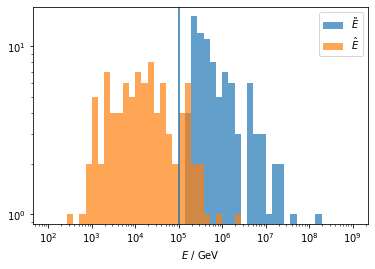

In [166]:
# Plot energies
Emin_cascades = sim_inputs['Emin']
bins = np.logspace(np.log(Emin_cascades/1000), np.log(1E+4*Emin_cascades), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins=bins, label='$\\tilde{E}$', alpha=0.7);
ax.hist(Edet_sim, bins=bins, label='$\hat{E}$', alpha=0.7);
ax.axvline(sim_inputs["Emin"])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

## Generate Stan code for fit

In [167]:
from python.backend.stan_generator import ParametersContext, TransformedParametersContext, ModelContext
from python.backend.variable_definitions import ParameterDef, ParameterVectorDef

In [168]:
with StanFileGenerator("stan_files/model_code") as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("energy_spectrum.stan")
        _ = Include("sim_functions.stan")
        ntd = NorthernTracksDetectorModel()
        
    with DataContext() as dc:
        
        # Neutrinos
        N = ForwardVariableDef("N", "int")
        N_str = ["[", N, "]"]
        omega_det = ForwardArrayDef("omega_det", "unit_vector[3]", N_str)
        Edet = ForwardVariableDef("Edet", "vector[N]")
        Emin = ForwardVariableDef("Emin", "real")
        
         # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        z = ForwardVariableDef("z", "vector[Ns+1]")

        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        
        # Inputs
        T = ForwardVariableDef("T", "real")
        
        # Debugging
        Q_scale = ForwardVariableDef("Q_scale", "real")
        F0_scale = ForwardVariableDef("F0_scale", "real")
        
        
    with TransformedDataContext() as tdc:
        
        zenith = ForwardVariableDef("zenith", "vector[N]")
        
        with ForLoopContext(1, N, "i") as i:
            zenith[i] << StringExpression(["pi() - acos(", omega_det[i][3], ")"])
        
        StringExpression(["print(", Ngrid, ")"])
            
    with ParametersContext() as pc:
        
        Q = ParameterDef("Q", "real", 0.0, 1e60)
        F0 = ParameterDef("F0", "real", 0.0, 500)
        
        alpha = ParameterDef("alpha", "real", 1.5, 3.5)
        
        Esrc = ParameterVectorDef("Esrc", "vector", N_str, Emin, 1e8)
        
    with TransformedParametersContext() as tpc:
        
        Fs = ParameterDef("Fs", "real", 0.0)
        
        F = ForwardVariableDef("F", "vector[Ns]")
        allF = ForwardVariableDef("allF", "vector[Ns+1]")
        eps = ForwardVariableDef("eps", "vector[Ns+1]")
        
        f = ParameterDef("f", "real", 0, 1)
        FT = ParameterDef("FT", "real", 0)
        
        lp = ForwardArrayDef("lp", "vector[Ns+1]", N_str)
        logF = ForwardVariableDef("logF", "vector[Ns+1]")
        Nex = ForwardVariableDef("Nex", "real")
        E = ForwardVariableDef("E", "vector[N]")       
        
        Fs << 0
        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([Q, "/ (4 * pi() * pow(", 
                                      D[k], " * ", 3.086e22, ", 2))"])
            allF[k] << F[k]
            StringExpression([Fs," += ", F[k]])
        StringExpression("allF[Ns+1]") << F0
        FT << F0 + Fs
        f << StringExpression([Fs, " / ", FT]) 
        
        logF << StringExpression(["log(", allF, ")"])
        
        with ForLoopContext(1, N, "i") as i:
            lp[i] << logF 
            with ForLoopContext(1, "Ns+1", "k") as k:
                StringExpression([lp[i][k], " += pareto_lpdf(", Esrc[i], 
                                  " | ", Emin, " , ", alpha-1, ")"])
                E[i] << StringExpression([Esrc[i], " / (",  1+z[k], ")"]) 
                
                StringExpression(["if (", k ," < Ns+1) {\n", 
                                  lp[i][k], " += ", 
                                  ntd.angular_resolution(E[i], 
                                                         varpi[k], omega_det[i]),
                                  ";\n}\n", "else if (", k, " == Ns+1) {\n", 
                                  lp[i][k], " += ", np.log(1/(4*np.pi)), 
                                  ";\n}"])
                
                StringExpression([lp[i][k], " += ", 
                                  ntd.energy_resolution(E[i], Edet[i])])
                       
        eps << StringExpression(["get_exposure_factor(", T, ", ", Emin, ", ", 
                                 alpha, ", ", alpha_grid, ", ", 
                                 integral_grid, ", ", Ns, ")"])  
        Nex << StringExpression(["get_Nex(", allF, ", ", eps, ")"])
    
    with ModelContext() as mc:
        
        with ForLoopContext(1, N, "i") as i:
            StringExpression(["target += log_sum_exp(", lp[i], ")"])
        StringExpression(["target += -", Nex])
        
        StringExpression([Q, " ~ normal(0, ", Q_scale, ")"])
        StringExpression([F0, " ~ normal(0, ", F0_scale, ")"])
        StringExpression([alpha, " ~ normal(2.0, 2.0)"])
        
    model = cg.generate_single_file()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x124ad49d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x125663510> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x124ad4710> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x1248f6290> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x1248f6090> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x124ad4e50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x124ad4250> already on stack
INFO:python.backend.code_gener

In [169]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]

sm = stan_utility.compile_model(filename=cg.filename, include_paths=include_paths, 
                                model_name="model")

Using cached StanModel


In [170]:
inputs = {}
inputs["N"] = len(Edet_sim)
inputs["omega_det"] = event.unit_vector
inputs["Edet"] = Edet_sim
inputs["Ns"] = source_list.N - 1

inputs['z'] = redshift
inputs['D'] = lum_dist[:-1]
inputs['varpi'] = varpi_in

inputs["Emin"] = 1e5 # GeV

inputs['Ngrid'] = len(exposure_integral.alpha_grid)
inputs['alpha_grid'] = exposure_integral.alpha_grid
inputs['integral_grid'] = exposure_integral.integral_grid
inputs["Q_scale"] = sim_inputs["Q"]
inputs["F0_scale"] = sim_inputs["F0"]
inputs["T"] = 1

In [171]:
# fit
fit = sm.sampling(data=inputs, iter=500, chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [174]:
# View chains
#fig = fit.plot([r'Q', r'F0', r'f', r'alpha', r'F', r"Nex"]);
#fig.set_size_inches(20, 16)
#fig.tight_layout()

In [175]:
# View corner plot
#chain = fit.extract(permuted = True)
#key_list = ['F0', 'Q', 'FT', 'f', 'alpha']
#labels = [r'$F_0$', r'Q', r'FT', r'f', 'alpha']
#truths = [sim_inputs['F0'], sim_inputs['Q'], 3.0, 0.5, sim_inputs['alpha']]

#corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
#              labels = labels, truths = truths);